This notebook is created on Google Colab. 
I could not use my laptop to run the Jupyter Notebook on Anaconda because of lack of resources required to run it locally. 

##Dataset Loading, BERT loading

Dataset : https://huggingface.co/datasets/tweet_eval/viewer/sentiment/train

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 20.0 MB/s 
     |████████████████████████████████| 7.6 MB 58.7 MB/s 
     |████████████████████████████████| 182 kB 58.3 MB/s 


In [3]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 451 kB 24.3 MB/s 
     |████████████████████████████████| 212 kB 76.7 MB/s 
     |████████████████████████████████| 132 kB 66.9 MB/s 
     |████████████████████████████████| 127 kB 68.1 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [4]:
# from sentence_transformers import SentenceTransformer
from transformers import DistilBertTokenizer, DistilBertModel
PRE_TRAINED_MODEL_NAME = 'distilbert-base-cased'
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased', return_dict = False, return_tensors="pt")


Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/411 [00:00<?, ?B/s]

In [5]:
from sklearn import preprocessing
import numpy as np
import re,string
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from timeit import default_timer

In [6]:
from datasets import load_dataset
dataset = load_dataset("tweet_eval", "sentiment")


Extracting data files #3:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #1:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #0:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #2:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #5:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #4:   0%|          | 0/1 [00:00<?, ?obj/s]

Generating train split:   0%|          | 0/45615 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/12284 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset tweet_eval downloaded and prepared to /root/.cache/huggingface/datasets/tweet_eval/sentiment/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
train_text = dataset['train']['text']
train_label = dataset['train']['label']


Spliting train dataset into test and val.

##EDA

In [8]:
##CUSTOM DEFINED FUNCTIONS TO CLEAN THE TWEETS

#Remove punctuations, links, mentions and \r\n new line characters
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text): # remove multiple spaces
    return re.sub("\s\s+" , " ", text)

In [42]:
texts_new = []
for t in train_text:
    texts_new.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(t)))))

In [10]:
texts_new[:10]

['qt in the original draft of the 7th book remus lupin survived the battle of hogwarts happybirthdayremuslupin',
 'ben smith smith concussion remains out of the lineup thursday curtis nhl sj',
 'sorry bout the stream last night i crashed out but will be on tonight for sure then back to minecraft in pc tomorrow night',
 'chase headleys rbi double in the 8th inning off david price snapped a yankees streak of 33 consecutive scoreless innings against blue jays',
 'alciato bee will invest 150 million in january another 200 in the summer and plans to bring messi by 2017',
 'lit my mum kerry the louboutins i wonder how many willam owns look kerry warner wednesday',
 'soul train oct 27 halloween special ft tdot finest rocking the miccrazy cactus night club adv ticket 10 wt out costume 15',
 'so disappointed in wwe summerslam i want to see john cena wins his 16th title',
 'this is the last sunday wo football nfl is back baby',
 'cena aj sitting in a tree kissing 1st goes ajs job then johns cred

In [11]:
# columns = ['text', 'label']

df = pd.DataFrame(texts_new, columns = ['text'])
text_len = []
for text in df.text:
    tweet_len = len(text.split())
    text_len.append(tweet_len)
df['text_len'] = text_len
df['label'] = train_label
print(df[:10])

                                                text  text_len  label
0  qt in the original draft of the 7th book remus...        17      2
1  ben smith smith concussion remains out of the ...        13      1
2  sorry bout the stream last night i crashed out...        24      1
3  chase headleys rbi double in the 8th inning of...        23      1
4  alciato bee will invest 150 million in january...        20      2
5  lit my mum kerry the louboutins i wonder how m...        16      2
6  soul train oct 27 halloween special ft tdot fi...        22      2
7  so disappointed in wwe summerslam i want to se...        15      0
8  this is the last sunday wo football nfl is bac...        11      2
9  cena aj sitting in a tree kissing 1st goes ajs...        21      1


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


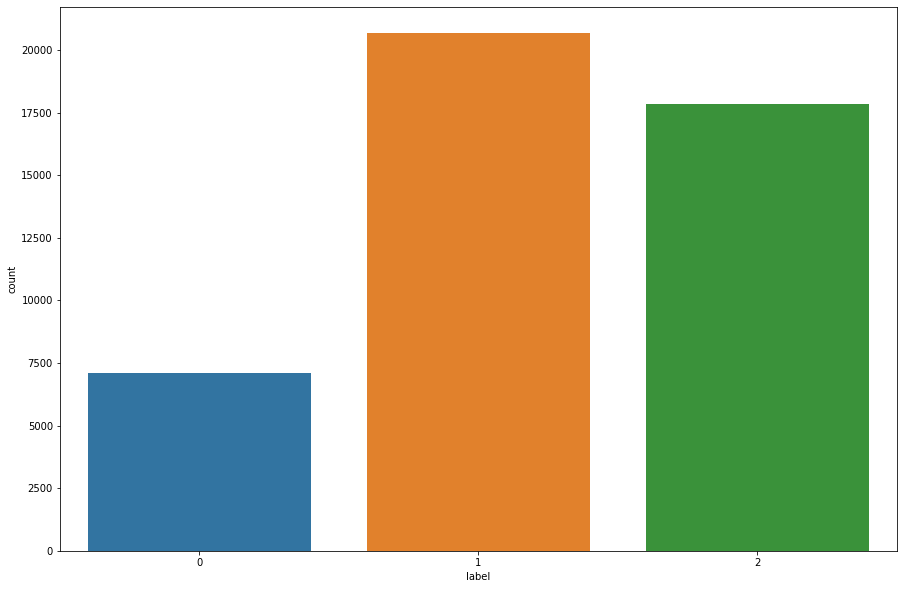

In [12]:
df['label'].value_counts()
plt.figure(figsize=(15,10))
sns.countplot(df.label)

Huge imbalance, so we use RandomUnderSampler to reduce the bias towards majority class

In [13]:
from imblearn.under_sampling import RandomUnderSampler
ros = RandomUnderSampler()
train_x, train_y = ros.fit_resample(np.array(df['text']).reshape(-1, 1), np.array(df['label']).reshape(-1, 1));
trainDataset = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['text', 'label']);

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


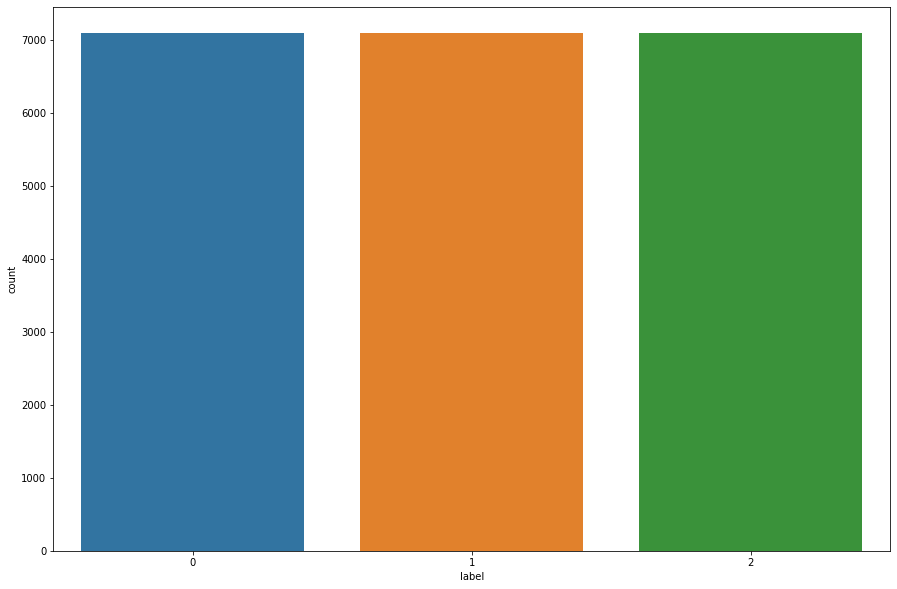

In [14]:
trainDataset['label'].value_counts()
plt.figure(figsize=(15,10))
sns.countplot(trainDataset.label)

Next we convert sentences into tokens

In [15]:
token_len = []
##1-2 mins on cpu
for txt in df.text:
  tokens = tokenizer.encode(txt, max_length=512)
  token_len.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


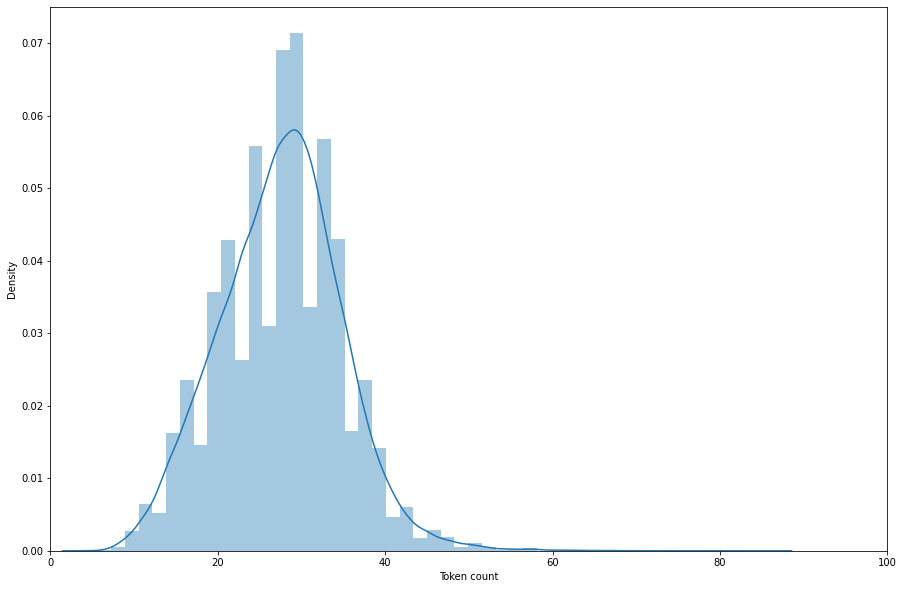

In [16]:
plt.figure(figsize=(15,10))
sns.distplot(token_len)
plt.xlim([0, 100]);
plt.xlabel('Token count');

In [17]:
MAX_LEN = 100


Creating pytorch dataset

In [18]:
from torch.utils.data import Dataset, DataLoader
class TwitterDataset(Dataset):

  def __init__(self, tweet, label, tokenizer, max_len):
    self.tweet = tweet
    self.label = label
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.tweet)
  
  def __getitem__(self, item):
    tweet = str(self.tweet[item])
    label = self.label[item]

    encoding = self.tokenizer.encode_plus(
      tweet,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'text': tweet,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'label': torch.tensor(label, dtype=torch.long)
    }

Test, Train and Val split

In [19]:
from sklearn.model_selection import train_test_split
RANDOM_SEED = 42
df_train, df_test = train_test_split(trainDataset, test_size=0.1, random_state=RANDOM_SEED, stratify = trainDataset.label.values)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED, stratify = df_test.label.values)

In [20]:
df_train.shape, df_val.shape, df_test.shape

## ((19151, 2), (1064, 2), (1064, 2))

((19151, 2), (1064, 2), (1064, 2))

In [21]:
df_train.head()

,text,label
9073,david wright may not be an everyday player whe...,1
7776,espn indians fire manager acta with six games ...,1
1311,caitlyn jenners car accident that killed someo...,0
15697,many thanks to zac brown for your support of t...,2
9699,music of the sunu002c a girl like meu002c good...,1


Creating DataLoader

In [22]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = TwitterDataset(
    tweet=df.text.to_numpy(),
    label=df.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [23]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [24]:
type(train_data_loader)

torch.utils.data.dataloader.DataLoader

In [25]:
data = next(iter(train_data_loader))


In [26]:
print(data['text'])
print(data['input_ids'])
print(data['attention_mask'].shape)
print(data['label'].shape)

['david wright may not be an everyday player when he returns until his back is full strength again tc says and that could be spring', 'espn indians fire manager acta with six games left the cleveland indians fired manager manny acta on thursdayu002c', 'caitlyn jenners car accident that killed someone was back in february so i believe she was still big brucey at that point', 'many thanks to zac brown for your support of the troops and the vetson monday night football', 'music of the sunu002c a girl like meu002c good girl gone badu002c rated ru002c loudu002c talk that talk', 'u2019really good dayu2019 as danica patrick finishes 10th at kansas nationwide race nascar news fox sports on msn vsowxx7c', 'kris bryant just hit a 2run bomb to tie it at 4 bottom 8th', 'thats not true its a pic from the month of january after charlie hebdo for the moment its forbidden to go out', 'lucas duda said he will get a second opinion in california on monday with doctor robert watkins who treated david wrig

## Model

In [27]:
db_model = DistilBertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict = False)

Downloading:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [28]:
from torch import nn, optim
import torch.nn.functional as F

In [29]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.db = DistilBertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict = False)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.db.config.hidden_size, n_classes)




  
  def forward(self, input_ids, attention_mask):
    # _, pooled_output = self.db(
    pooled_output = self.db(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    
    # print(pooled_output[0].shape)
    output = self.drop(pooled_output[0])
    # print(output.shape)
    return self.out(output)





In [30]:
class_names = [0,1,2]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [31]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
label = data['label'].to(device)
print(input_ids.shape) # batch size x seq length
print(label.shape) # batch size x seq length

torch.Size([16, 100])
torch.Size([16])


In [32]:
model(input_ids, attention_mask).shape

## torch.Size([16, 100, 3])

torch.Size([16, 100, 3])

In [33]:
F.softmax(model(input_ids, attention_mask), dim = 1)

tensor([[[0.0087, 0.0102, 0.0133],
         [0.0106, 0.0126, 0.0106],
         [0.0107, 0.0102, 0.0077],
         ...,
         [0.0096, 0.0091, 0.0074],
         [0.0092, 0.0086, 0.0089],
         [0.0136, 0.0098, 0.0103]],

        [[0.0091, 0.0097, 0.0099],
         [0.0064, 0.0160, 0.0115],
         [0.0135, 0.0111, 0.0109],
         ...,
         [0.0104, 0.0096, 0.0101],
         [0.0101, 0.0089, 0.0080],
         [0.0080, 0.0094, 0.0073]],

        [[0.0133, 0.0076, 0.0116],
         [0.0089, 0.0119, 0.0118],
         [0.0134, 0.0094, 0.0145],
         ...,
         [0.0094, 0.0091, 0.0086],
         [0.0102, 0.0108, 0.0104],
         [0.0107, 0.0085, 0.0088]],

        ...,

        [[0.0104, 0.0098, 0.0107],
         [0.0153, 0.0137, 0.0094],
         [0.0109, 0.0098, 0.0092],
         ...,
         [0.0103, 0.0099, 0.0085],
         [0.0132, 0.0135, 0.0116],
         [0.0092, 0.0105, 0.0099]],

        [[0.0103, 0.0096, 0.0101],
         [0.0097, 0.0104, 0.0083],
         [0.

##Training

In [34]:
from transformers import AdamW, get_linear_schedule_with_warmup
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [35]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    label = d["label"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )


    outputs = torch.mean(outputs, dim=1)



    loss = loss_fn(outputs, label)

    _, preds = outputs.max(dim = 1)


    correct_predictions += torch.sum(preds == label)


    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [36]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      label = d["label"].to(device)

      outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )


      outputs = torch.mean(outputs, dim=1)



      loss = loss_fn(outputs, label)

      _, preds = outputs.max(dim = 1)


      correct_predictions += torch.sum(preds == label)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [37]:
%%time
from collections import defaultdict
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.7436308135016321 accuracy 0.6681113257793326
Val   loss 0.7061734288486082 accuracy 0.6898496240601504

Epoch 2/10
----------
Train loss 0.4812076299411611 accuracy 0.8027257062294397
Val   loss 0.7672334429043443 accuracy 0.6889097744360901

Epoch 3/10
----------
Train loss 0.28460591185897116 accuracy 0.8938436635162654
Val   loss 0.978154061223144 accuracy 0.674812030075188

Epoch 4/10
----------
Train loss 0.17969806675332656 accuracy 0.9407341653177379
Val   loss 1.5971952537769702 accuracy 0.6672932330827067

Epoch 5/10
----------
Train loss 0.12287445418895926 accuracy 0.9640749830296068
Val   loss 1.9261201061308384 accuracy 0.6682330827067668

Epoch 6/10
----------
Train loss 0.08849957841040011 accuracy 0.9736828364054096
Val   loss 2.2435769185201444 accuracy 0.6729323308270676

Epoch 7/10
----------
Train loss 0.06831891359905479 accuracy 0.9803665604929246
Val   loss 2.4115689831434874 accuracy 0.674812030075188

Epoch 8/10
----------
Tra

In [38]:
history_new = {'train' : [], 'val' : []}
for i in range(0, 10):
  history_new['train'].append(history['train_acc'][i].item())
  history_new['val'].append(history['val_acc'][i].item())

In [39]:
history_new

{'train': [0.6681113257793326,
  0.8027257062294397,
  0.8938436635162654,
  0.9407341653177379,
  0.9640749830296068,
  0.9736828364054096,
  0.9803665604929246,
  0.9880946164691139,
  0.9920108610516422,
  0.993838441856822],
 'val': [0.6898496240601504,
  0.6889097744360901,
  0.674812030075188,
  0.6672932330827067,
  0.6682330827067668,
  0.6729323308270676,
  0.674812030075188,
  0.6776315789473684,
  0.6757518796992481,
  0.68796992481203]}

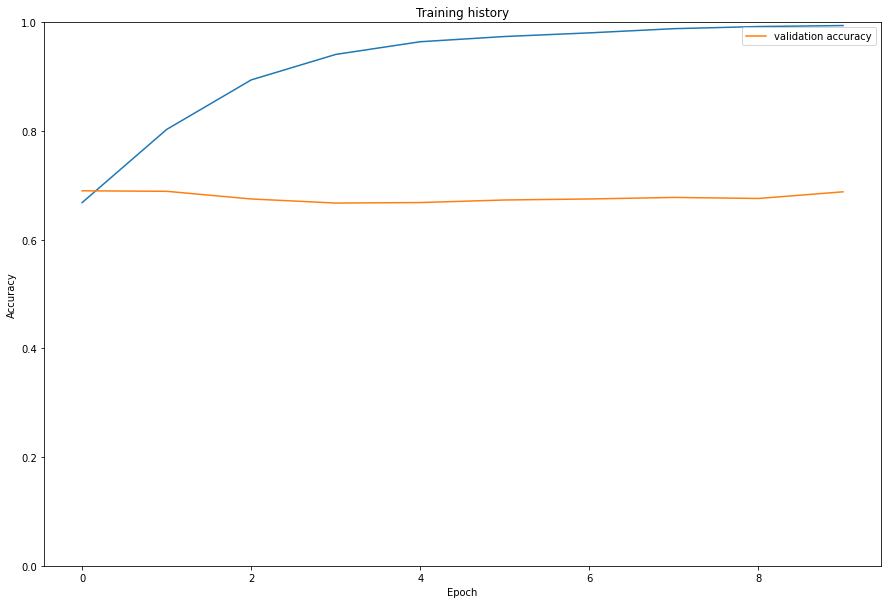

In [40]:
plt.figure(figsize = (15,10))
plt.plot(history_new['train'])
plt.plot(history_new['val'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [41]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.6729323308270676

As we can see the validation loss is not decreasing, it means the model is overfitting 